Evaluate SB limit after N years

Still to do:
* use seeing in db rather than assuming fixed seeing
* Add and recover fake galaxies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import math

In [12]:
# This is needed to avoid an error when a metric is redefined
from lsst.sims.maf.metrics import BaseMetric
try:
    del metrics.BaseMetric.registry['__main__.SB']
except KeyError:
    pass

In [13]:
class SB(BaseMetric):
    """Calculate the SB at this gridpoint."""
    def __init__(self, m5Col = 'fiveSigmaDepth', metricName='SB', **kwargs):
        """Instantiate metric.

        m5col = the column name of the individual visit m5 data."""
        super(SB, self).__init__(col=m5Col, metricName=metricName, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        seeing = 0.7
        return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])) * (math.pi*seeing**2))

Let's compare the depth in the r-band after 5 years, and the depth after 5 years when the seeing is better than 0.7 arcseconds

In [14]:
filterName = 'r'
years = [1, 2, 3, 5, 10]
nights = np.array(years)*365.25
sqls = ['filter = "%s" and night < %f' %(filterName, night) for night in nights]
print sqls

['filter = "r" and night < 365.250000', 'filter = "r" and night < 730.500000', 'filter = "r" and night < 1095.750000', 'filter = "r" and night < 1826.250000', 'filter = "r" and night < 3652.500000']


In [15]:
# Set up the database connection
dbdir = '/Users/loveday/sw/lsst/enigma_1189/'
opsdb = db.OpsimDatabase(database = os.path.join(dbdir, 'enigma_1189_sqlite.db'))
outDir = 'GoodSeeing'
resultsDb = db.ResultsDb(outDir=outDir)

# opsdb.tables['Summary'].columns

In [16]:
slicer = slicers.HealpixSlicer()
summaryMetrics = [metrics.MeanMetric(), metrics.MedianMetric()]
metric = SB()
bgroupList = []
for year,sql in zip(years,sqls):
    bundle = metricBundles.MetricBundle(metric, slicer, sql, summaryMetrics=summaryMetrics)
    bundle.plotDict['label'] = '%i' % year
    bgroup = metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgroupList.append(bgroup)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database with constraint filter = "r" and night < 365.250000
Found 37613 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 25.6702  dipole: lon: 5.9154, lat: -37.5629, amp: 0.676421
Plotting complete.
Querying database with constraint filter = "r" and night < 730.500000
Found 97971 visits
Running:  [0]
Completed metric generation.

Optimal bin calculation tried to make 221 bins, returning 200
Optimal bin calculation tried to make 250 bins, returning 200



Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 26.5692  dipole: lon: 54.2213, lat: 76.2273, amp: 0.130016
Plotting complete.
Querying database with constraint filter = "r" and night < 1095.750000
Found 151614 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 26.7974  dipole: lon: 36.3221, lat: 70.4638, amp: 0.18638
Plotting complete.
Querying database with constraint filter = "r" and night < 1826.250000
Found 271240 visits
Running:  [0]
Completed metric generation.

Optimal bin calculation tried to make 302 bins, returning 200
Optimal bin calculation tried to make 321 bins, returning 200



Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 27.088  dipole: lon: 70.7624, lat: 65.6294, amp: 0.160873
Plotting complete.
Querying database with constraint filter = "r" and night < 3652.500000
Found 544710 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 27.3713  dipole: lon: 82.546, lat: 26.7924, amp: 0.0524659
Plotting complete.


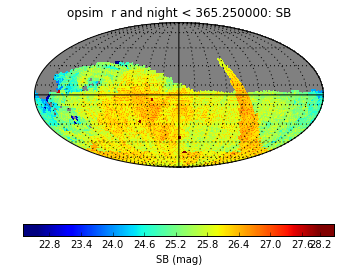

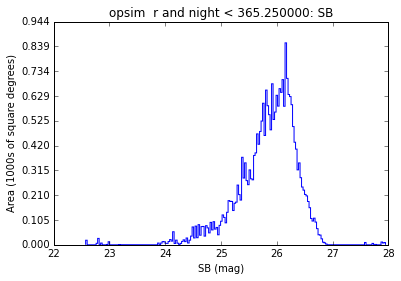

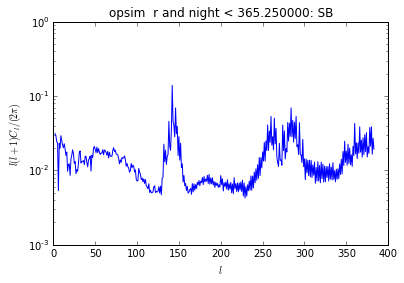

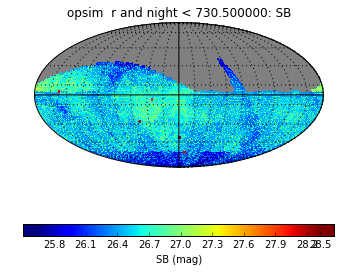

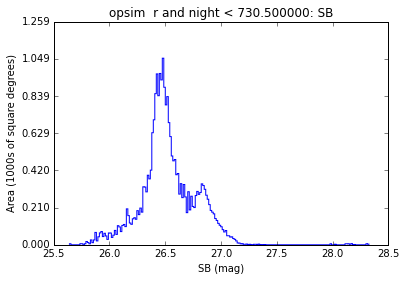

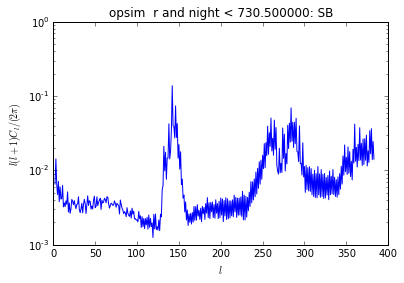

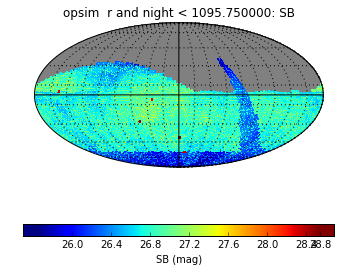

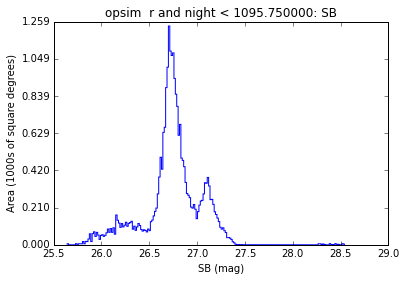

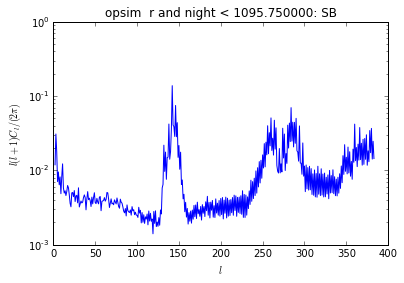

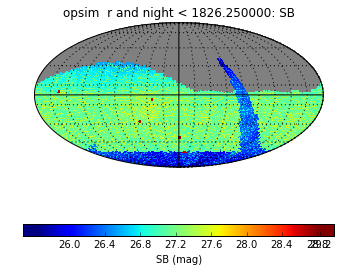

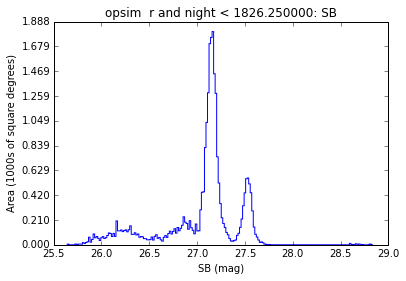

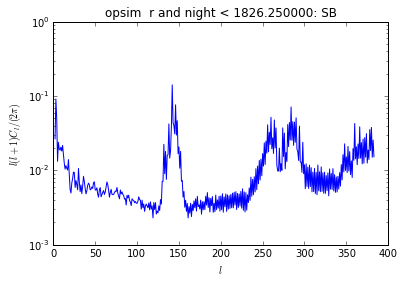

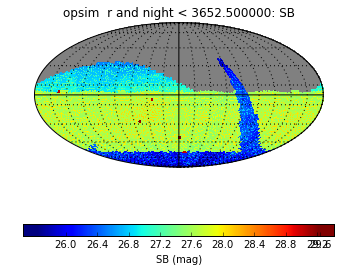

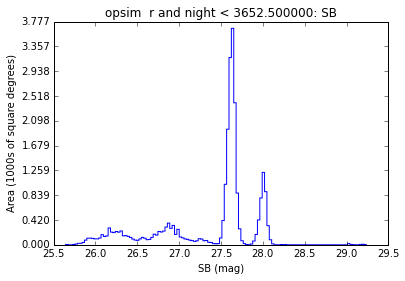

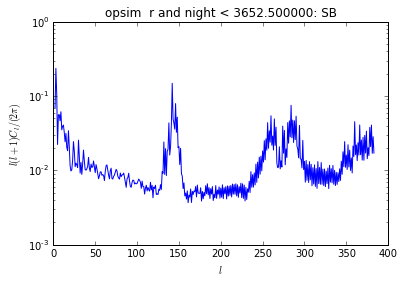

In [17]:
for bgroup in bgroupList:
    bgroup.runAll()
    bgroup.plotAll(closefigs=False)

In [18]:
mean_depth = []
median_depth = []
print 'year, mean depth, median depth'
for year,bundleGroup in zip(years,bgroupList):
    mean_depth.append(bundleGroup.bundleDict[0].summaryValues['Mean'])
    median_depth.append(bundleGroup.bundleDict[0].summaryValues['Median'])
    print (year, bundleGroup.bundleDict[0].summaryValues['Mean'], 
           bundleGroup.bundleDict[0].summaryValues['Median'])

year, mean depth, median depth
(1, 25.837173531793887, 25.920805356698082)
(2, 26.527296892506286, 26.496581627902533)
(3, 26.739518705108349, 26.74563654167715)
(5, 27.042509453420646, 27.1406354013818)
(10, 27.367334108960069, 27.61097878667108)


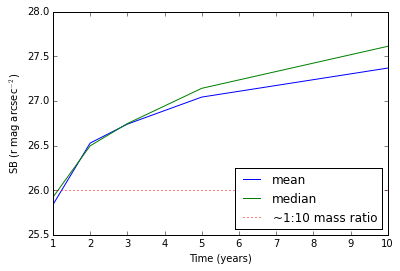

In [19]:
    # Plot SB limits as fn of time
    plt.clf()
    plt.plot(years, mean_depth, label='mean')
    plt.plot(years, median_depth, label='median')
    plt.plot((years[0], years[-1]), (26, 26), ':', label='~1:10 mass ratio')
    plt.xlabel('Time (years)')
    plt.ylabel(r'SB (r mag arcsec$^{-2}$)')
    plt.legend(loc=4)
    plt.show()
    